Script for generating Fig 2 which demonstrates the success of the control simulation at generating AABW from shelf sourced dense waters:
- Simulated dense water formation on the Antarctic continental shelf and transport pathways to the abyssal ocean. The surface water-mass transformation rate per unit area across $\sigma_1=32.51$ kg m$^{-3}$, into downwelling density classes, is shown on the continental shelf in red shading. Green shading in the open ocean shows passive age tracer values for the bottom ocean grid cell, normalised by the simulation length. 
Dark green shading indicates the presence of recently ventilated shelf-sourced dense waters at the seabed. 
Black arrows interpret the pathways along which these shelf-sourced dense waters propagate northwards as AABW. Time averaged output for the 10 year control simulation is shown. Black and grey lines are the 1000 m and 4000 m isobaths respectively, which delineate the continental shelf and abyssal ocean regions.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from matplotlib import gridspec
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib import rc, rcParams
rc('text', usetex=True)
import cmocean.cm as cmo
from gsw import SA_from_SP, p_from_z, CT_from_pt, sigma1
import matplotlib.ticker as mticker
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [2]:
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=40) 
rc('ytick', labelsize=40) 
rc('axes', labelsize=40) 

In [3]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'

Below is the script used to compute surface water mass transformation rates from heat and salt transfer in the southern hemisphere. Details can be found in my cosima cookbook contribution surface_water-mass_transformation.nb.

In [4]:
def save_SWMT(expt, session, start_time, end_time, outpath, lat_north = -59, n = None):
    '''
    Computes southern ocean surface water-mass transformation rates (partitioned into transformation from heat 
    and freshwater) referenced to 1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output (the scattered .load()'s allowed this)
    
    expt - text string indicating the name of the experiment
    session - a database session created by cc.database.create_session()  
    start_time - text string designating the start month of the analysis ('YYYY-MM', e.g. '1905-01')
    end_time - text string indicating the end month of the analysis ('YYY-MM', e.g. '1905-12')
    outpath - text string indicating directory where output databases are to be saved (3 xarray databases, can
    modify to combine these if memory permits)
    lat_north - function computed processes between lat = -90 and lat = lat_north
    n - designate if a subset of output files is to be considered (see cc.querying.getvar)
    
    NOTE: this function assumes you are averaging over an integer number of years (though the start month 
    need not be january, e.g. can have start_time = '1905-05', end_time = '1907-04' etc), modify if otherwise.
    
    NOTE: assumes surface_temp and surface_salt variables are in potential temperature (K) and practical
    salinity (PSU), simplifications may be made if conservative temperature (C) and absolute salinity (g/kg)
    are computed online
    
    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt,'surface_temp',session) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt,'surface_salt',session) # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt,'pme_river',session) # mass flux of precip - evap + river
    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session) # W/m2
    sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session) # W/m2
    sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session) # W/m2
    frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session) # W/m2
    geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
    geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time,end_time)
    lat_slice = slice(-90,lat_north)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    ## extract coordinate arrays
    yt_ocean = SST.yt_ocean.values
    xt_ocean = SST.xt_ocean.values
    time_monthly = SST.time.values
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
    ## compute net surface heat flux from its component terms
    net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -0.541281 # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0+1)*depth
    pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    salt_transformation = haline_contraction*SSS*pme_river*days_per_month #! before was PSU, why?
    salt_transformation = salt_transformation.load()
    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation =  thermal_expansion*net_surface_heating*days_per_month
    heat_transformation = heat_transformation.load()
    # Record the time bounds before summing through time (just to make sure it's consistent with requested years)
    time_bounds =  str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31,33.5,.02) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
    
    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins':1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,:,:] = masked_transform
    print('salt_transformation binning done')
    
    binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins':1})

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,:,:] = masked_transform
    print('heat_transformation binning done')
    
    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays
    
    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
    heat_transformation = heat_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2
    
    # this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1
    
    # Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
    ds = xr.Dataset({'binned_salt_transformation': salt_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/ST_'+time_bounds+'.nc')
    ds = xr.Dataset({'binned_heat_transformation': heat_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/HT_'+time_bounds+'.nc')
    #############################################################
    net_transformation = heat_transformation + salt_transformation
    #############################################################
    del(heat_transformation, salt_transformation) ## unecessary for lower res or smaller time
    # wanted to rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
    net_transformation.coords['isopycnal_bins'] = isopycnal_bin_mid
    ds = xr.Dataset({'surface_water_mass_transformation': net_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/SWMT_'+time_bounds+'.nc')
    del(net_transformation)
    return outpath, time_bounds ## helpful for re-loading

But I already ran this so I'm just going to re-load previous computation.

In [5]:
def get_SWMT(dirpath, time_bounds):
    net_transformation = xr.open_dataset(dirpath+'SWMT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(dirpath+'HT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(dirpath+'ST_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation
    return  net_transformation, heat_transformation, salt_transformation

In [6]:
net_transformation = get_SWMT('/g/data/v45/rm2389/SWMT/01deg_jra55v13_ryf8485_spinup6/', '1937_6-1940_5')[0]
area_t = cc.querying.getvar(control, 'area_t',session, n = 1)
area_t = area_t.sel(yt_ocean = slice(-90, -59))
area_t = area_t.load()
net_transformation, shelf_mask = shelf_mask_isobath(net_transformation)
net_sum = (net_transformation* area_t/1e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values
max_transformation_index = np.argmin(net_sum) 
isopycnal_bin_mid = net_transformation.isopycnal_bins.values
max_transformation_density = isopycnal_bin_mid[max_transformation_index]
net_plot = net_transformation.isel(isopycnal_bins = max_transformation_index)*1e5*-1
swmt_xt = net_plot.xt_ocean
swmt_yt = net_plot.yt_ocean
net_plot = net_plot.where(net_plot>0).values

Now we want to get the age in the bottom cell, normalised by the simulation age, masked for only off the shelf.

In [7]:
age = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/control_mean_age.nc', chunks = {'st_ocean':None, 'xt_ocean':300, 'yt_ocean':300})
age = age.age
dummy = age * 0 + 1
depth_array = dummy * 0 + dummy.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
bottom_mask = depth_array.where(depth_array.st_ocean >= max_depth) * 0 + 1
bottom_age = age * bottom_mask
bottom_age = bottom_age.sum(dim = 'st_ocean')
bottom_age = bottom_age.load()

In [12]:
## create a mask that masks OUT the shelf (opposite of function shelf_mask_isobath)
yt_ocean_full = age.sel(yt_ocean = slice(-90,-55)).yt_ocean
xt_ocean = age.xt_ocean
yt_ocean_add = yt_ocean_full.sel(yt_ocean = slice(-59, None))
extra_rows = np.zeros((74,3600))
shelf_mask_extended = np.append(shelf_mask.values, extra_rows, axis = 0)
shelf_mask_ext  = xr.DataArray(shelf_mask_extended,coords = [('yt_ocean', yt_ocean_full), ('xt_ocean', xt_ocean)] )
shelf_mask_ext = shelf_mask_ext.where(shelf_mask_ext == 0) + 1

In [13]:
max_age = bottom_age.max().values
age_norm = bottom_age/max_age
age_norm = age_norm.sel(yt_ocean = slice(-90,-55))
age_norm_off = age_norm * shelf_mask_ext
age_norm_off = age_norm_off.load()

In [15]:
## data required for lat/lon mapping and bathymetry contours
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [16]:
contour_4000m = ht.sel(yt_ocean = slice(-90,-55))
contour_4000m = contour_4000m.where(contour_4000m > 4000)
contour_4000m = contour_4000m * 0 + 1
contour_4000m = contour_4000m.fillna(0)

In [18]:
## some stuff that I always plot when doing circumantarctic thingies
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
def antarctic_map(ax, isobath_linewidth, grid, north, isobath_colour = 'k'):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = isobath_colour, linewidth = isobath_linewidth, transform=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, north], ccrs.PlateCarree())
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--')
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50])

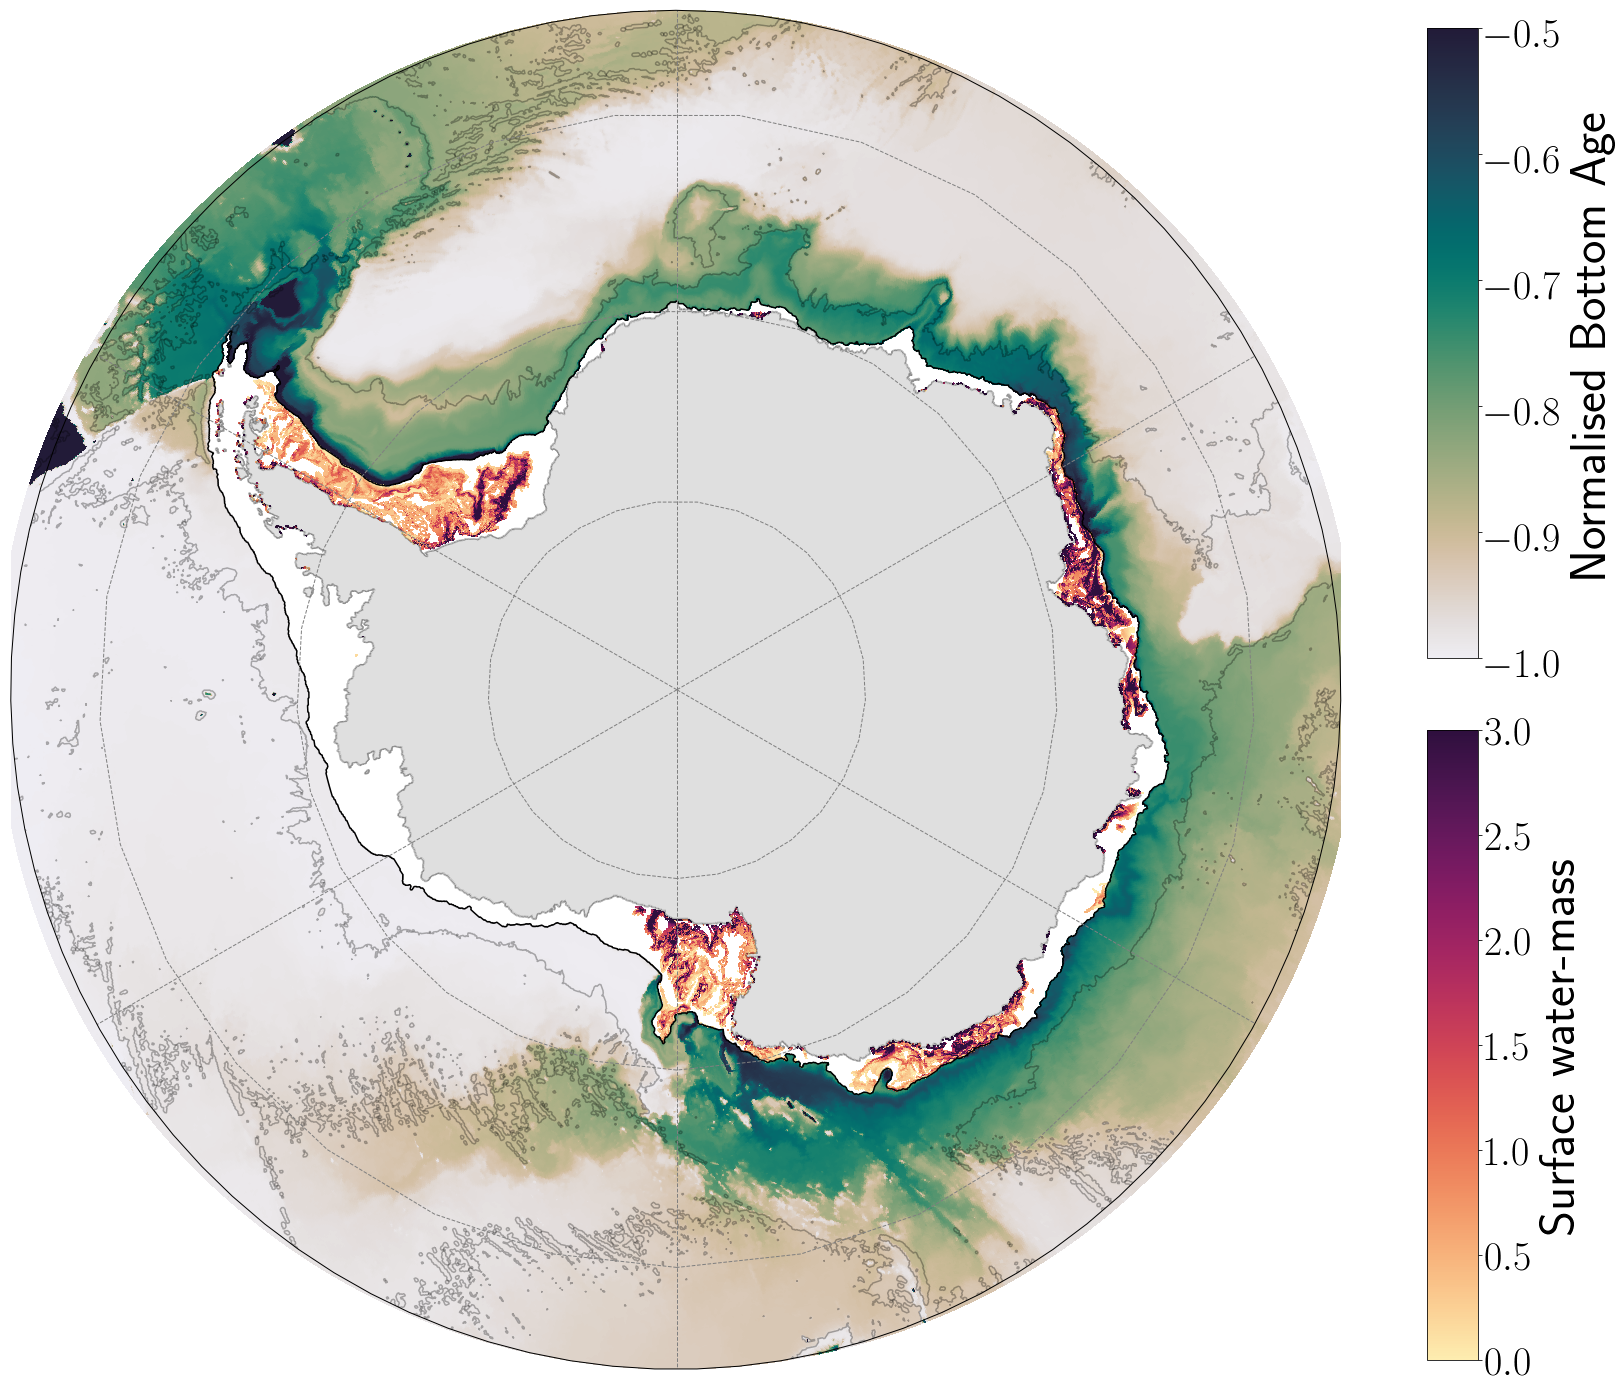

In [19]:
fig  = plt.figure(1, figsize = (25,25))
ax0= plt.subplot(projection=ccrs.SouthPolarStereo())

fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)

## age difference
norm = col.Normalize(vmin=-1,vmax=-0.5)
plot = ax0.pcolormesh(age_norm_off.xt_ocean,age_norm_off.yt_ocean,-age_norm_off,cmap = cmo.rain, norm = norm,transform = ccrs.PlateCarree())
antarctic_map(ax0, isobath_linewidth = 6, grid = True, north = -55)
ax0.contour(contour_4000m.xt_ocean, contour_4000m.yt_ocean,contour_4000m,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform = ccrs.PlateCarree())
## swmt
norm = col.Normalize(vmin=0,vmax=3)
plot_swmt = ax0.pcolormesh(swmt_xt,swmt_yt,net_plot,norm=norm,cmap= cmo.matter,transform=ccrs.PlateCarree())

cax = fig.add_axes([0.93, 0.52, 0.028, 0.35])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-1,-0.9,-0.8,-0.7,-0.6,-0.5])
cbar.set_label(r'Normalised Bottom Age', fontsize = 50)

cax = fig.add_axes([0.93, 0.13, 0.028, 0.35])
cbar=plt.colorbar(plot_swmt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [0, 0.5,1, 1.5,2,2.5,3])
cbar.set_label(r'Surface water-mass', fontsize = 50)

figurepath = 'Fig2.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)
plt.show()

With photoeditting tools I added some arrows indicating the direction of bottom water flow and lat/lon values.